## RDMM (Recurrent Deterministic Market Maker)
**Paper mapping (Cartea, Jaimungal, Sánchez-Betancourt):**
- Sec. 3.3 & App. B: recurrent agent with hidden state h_t (LSTMCell here)
- Eq. (12): h_t = f(h_{t-1}, o_t, q_t)  --> RDMMEncoder
- Eq. (13): a_t ~ π_θ(h_t)              --> RDMMActor (deterministic)
- Sec. 3.3.2: double Q-learning w/ targets --> TD3-style twin critics & target nets
- Table 1 (state features): o_t includes mid-prices, spread, inventory (we use observation + engineered spread)

In [275]:
import os, sys
sys.path.append(os.path.abspath(".."))
sys.path.append(os.path.abspath("."))
from envs.fx_triplet_env import FXTripletEnv, FXTripletConfig
import os
import math
from dataclasses import dataclass
from typing import Optional, Tuple, List

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from dataclasses import dataclass

**Utilities**

In [277]:
def fanin_init(module: nn.Module, scale: float = 1.0):
    if isinstance(module, nn.Linear):
        lim = scale / math.sqrt(module.in_features)
        nn.init.uniform_(module.weight, -lim, lim)
        nn.init.zeros_(module.bias)

**RDMM Components**

In [279]:
class RDMMEncoder(nn.Module):
    """
    Recurrent encoder implementing the paper's Eq. (12) idea:
      h_t = f_theta(h_{t-1}, [o_t, q_t])
    We use an LSTMCell (App. B mentions recurrent hidden state; LSTM stabilizes training).
    Input per step: x_t = concat(o_t, q_t, engineered spreads, time features).
    Output: (h_t, c_t)
    """
    def __init__(self, input_dim: int, hidden_dim: int):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTMCell(input_dim, hidden_dim)
        # Light projection (optional) to stabilize scale of h
        self.proj = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Tanh()
        )

        # init
        for m in self.modules():
            if isinstance(m, nn.Linear):
                fanin_init(m, 1.0)

    def forward(self, x_t: torch.Tensor, h: Optional[Tuple[torch.Tensor, torch.Tensor]] = None):
        """
        x_t: (B, input_dim)
        h: (h_t-1, c_t-1), each (B, hidden_dim)
        returns: h_t, c_t, h_proj (projected hidden used by heads)
        """
        if h is None:
            B = x_t.size(0)
            h_prev = x_t.new_zeros((B, self.hidden_dim))
            c_prev = x_t.new_zeros((B, self.hidden_dim))
        else:
            h_prev, c_prev = h
        h_t, c_t = self.lstm(x_t, (h_prev, c_prev))
        h_proj = self.proj(h_t)
        return (h_t, c_t), h_proj


class RDMMActor(nn.Module):
    """
    Deterministic policy π_θ(h_t) -> a_t in R^3 (EUR, GBP, cross dimension)
    Paper Sec. 3.3 & Eq. (13).
    Actions are squashed by tanh and scaled to env action bounds.
    """
    def __init__(self, hidden_dim: int, action_dim: int = 3, max_action: float = 1.0):
        super().__init__()
        self.max_action = float(max_action)
        self.net = nn.Sequential(
            nn.Linear(hidden_dim, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, action_dim)
        )
        self.tanh = nn.Tanh()
        # init
        for m in self.modules():
            if isinstance(m, nn.Linear):
                fanin_init(m, 0.5)

    def forward(self, h_proj: torch.Tensor) -> torch.Tensor:
        a = self.net(h_proj)
        a = self.tanh(a) * self.max_action
        return a


class RDMMCritic(nn.Module):
    """
    Q(h_t, a_t) per Sec. 3.3.2; TD3 uses two critics (we'll instantiate two of these).
    Input: concatenated [h_proj, a]
    Output: scalar Q-value
    """
    def __init__(self, hidden_dim: int, action_dim: int = 3):
        super().__init__()
        self.q = nn.Sequential(
            nn.Linear(hidden_dim + action_dim, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )
        # init
        for m in self.modules():
            if isinstance(m, nn.Linear):
                fanin_init(m, 0.5)

    def forward(self, h_proj: torch.Tensor, a: torch.Tensor) -> torch.Tensor:
        x = torch.cat([h_proj, a], dim=-1)
        return self.q(x)

## Replay Buffer (stores recurrent context)

In [281]:
class RecurrentReplay:
    """
    Stores single-step transitions with the recurrent hidden state snapshot.
    We store (obs, feat, h_proj, action, reward, next_obs, next_feat, next_h_proj, done).
    For stability (and to avoid backprop through time via buffer), h_proj is treated as a feature.
    """
    def __init__(self, capacity: int, seed: Optional[int] = None):
        self.capacity = int(capacity)
        self.rng = np.random.default_rng(seed)
        self.ptr = 0
        self.full = False
        self.data = None

    def _init_storage(self, example):
        obs, feat, hproj, a, r, nob, nfeat, nhproj, done = example
        B = self.capacity
        self.data = {
            "obs": np.zeros((B, *obs.shape), dtype = np.float32),
            "feat": np.zeros((B, feat.shape[-1]), dtype = np.float32),
            "hproj": np.zeros((B, hproj.shape[-1]), dtype = np.float32),
            "act": np.zeros((B, a.shape[-1]), dtype = np.float32),
            "rew": np.zeros((B, 1), dtype = np.float32),
            "nobs": np.zeros((B, *nob.shape), dtype = np.float32),
            "nfeat": np.zeros((B, nfeat.shape[-1]), dtype = np.float32),
            "nhproj": np.zeros((B, nhproj.shape[-1]), dtype = np.float32),
            "done": np.zeros((B, 1), dtype = np.float32),
        }

    def push(self, obs, feat, hproj, act, rew, nobs, nfeat, nhproj, done):
        example = (obs, feat, hproj, act, np.array([rew], np.float32), nobs, nfeat, nhproj, np.array([done], np.float32))
        if self.data is None:
            self._init_storage(example)
        i = self.ptr
        self.data["obs"][i] = example[0]
        self.data["feat"][i] = example[1]
        self.data["hproj"][i] = example[2]
        self.data["act"][i] = example[3]
        self.data["rew"][i] = example[4]
        self.data["nobs"][i] = example[5]
        self.data["nfeat"][i] = example[6]
        self.data["nhproj"][i] = example[7]
        self.data["done"][i] = example[8]
        self.ptr = (self.ptr + 1) % self.capacity
        self.full = self.full or (self.ptr == 0)
    
    def __len__(self):
        return self.capacity if self.full else self.ptr

    def sample(self, batch_size: int):
        assert len(self) >= batch_size, "Not enough samples"
        idx = self.rng.integers(0, len(self), size = batch_size)
        batch = {k: v[idx] for k, v in self.data.items()}
        return batch

## Single TD3 training step

In [283]:
def train_step(self):
    if len(self.replay) < self.cfg.batch_size:
        return None

    batch = self.replay.sample(self.cfg.batch_size)
    obs_b, feat_b, hproj_b, act_b, rew_b, nobs_b, nfeat_b, nhproj_b, done_b = \
        (batch["obs"], batch["feat"], batch["hproj"], batch["act"], batch["rew"],
        batch["nobs"], batch["nfeat"], batch["nhproj"], batch["done"])

    # to torch
    obs_t, feat_t, hproj_t, act_t, rew_t, nobs_t, nfeat_t, nhproj_t, done_t = self._to_torch(
         obs_b, feat_b, hproj_b, act_b, rew_b, nobs_b, nfeat_b, nhproj_b, done_b
    )

    # Critic update (TD3 target with smoothing)
    with torch.no_grad():
        # target action π_t(nh)
        a_targ = self.actor_t(nhproj_t)
        # add clipped noise (policy smoothing)
        noise = torch.clamp(
            torch.randn_like(a_targ) * self.cfg.target_noise_std,
            -self.cfg.target_noise_clip, self.cfg.target_noise_clip
        )
        a_targ = torch.clamp(a_targ + noise, -self.max_action, self.max_action)

        # twin target critics
        q1_next = self.critic1_t(nhproj_t, a_targ)
        q2_next = self.critic2_t(nhproj_t, a_targ)
        q_next = torch.min(q1_next, q2_next)
        y = rew_t + (1.0 - done_t) * (self.cfg.gamma * q_next)

    # current Q estimates
    q1 = self.critic1(nhproj_t, act_t)
    q2 = self.critic2(nhproj_t, act_t)
    critic_loss = nn.MSELoss()(q1, y) + nn.MSELoss()(q2, y)

    self.opt_critic.zero_grad(set_to_none = True)
    critic_loss.backward()
    nn.utils.clip_grad_norm_(list(self.critic1.parameters()) + list(self.critic2.parameters()), 10.0)
    self.opt_critic.step()

    info = {"critic_loss": float(critic_loss.item())}


    # Delayed policy update (every policy_delay steps)
    self.grad_steps += 1
    if(self.grad_steps % self.cfg.policy_delay) == 0:
        # Actor loss: maximize Q1(h, π(h)) => minimize -Q1
        a_pi = self.actor(hproj_t)
        actor_loss = -self.critic1(hproj_t, a_pi).mean()

        self.opt_actor.zero_grad(set_to_none = True)
        actor_loss.backward()
        nn.utils.clip_grad_norm_(self.actor.parameters(), 10.0)
        self.opt_actor.step()
        info["actor_loss"] = float(actor_loss.item())

        # Soft-update targets
        self._soft_update(self.encoder, self.encoder_t)
        self._soft_update(self.actor, self.actor_t)
        self._soft_update(self.critic1, self.critic1_t)
        self._soft_update(self.critic2, self.critic2_t)

    return info

## Evaluation (greedy policy)

In [285]:
@torch.no_grad()
def evaluate(self, n_episodes: int = 20):
    avg_reward = 0.0
    for _ in range(n_episodes):
        obs = self.env.reset()
        # reset recurrent state for episode
        self.hc = None
        ep_r = 0.0
        for _t in range(self.env.cfg.T):
            a, feat, hproj_np = self.select_action(obs, explore=False)
            next_obs, r, done, info = self.env.step(a)
            ep_r += r
            obs = next_obs
            if done:
                break
        avg_reward += ep_r
    avg_reward /= n_episodes
    print(f"[Eval] avg_reward over {n_episodes} eps = {avg_reward:.6f}")
    return avg_reward

## Full training loop (step budget)

In [287]:
def train(self):
    self.total_steps = 0
    episode = 0
    best_eval = -np.inf
    self.reward_history = []

    while self.total_steps < self.cfg.max_env_steps:
        episode += 1
        obs = self.env.reset()
        self.hc = None
        ep_reward = 0.0

        for step_in_ep in range(self.env.cfg.T):
            # collect action
            if self.total_steps < self.cfg.start_steps:
                # warmup: random action in Box bounds
                a = self.rng.uniform(low = self.env.action_space.low,
                                    high = self.env.action_space.high).astype(np.float32)
                feat = self._make_feats(obs)
                # forward encoder with current input to maintain recurrent state (but we don't use policy during warmup)
                enc_in = np.concatenate([obs.astype(np.float32), feat], axis=0)[None, ...]
                enc_in_t = torch.as_tensor(enc_in, dtype=torch.float32, device=self.device)
                self.hc, hproj_t = self.encoder(enc_in_t, self.hc)
                hproj_np = hproj_t.cpu().numpy()[0]
            else:
                a, feat, hproj_np = self.select_action(obs, explore=True)

            # env step
            next_obs, r, done, info = self.env.step(a)
            next_feat = self._make_feats(next_obs)

            # compute next hproj (without policy) to store in buffer target branch
            enc_in_next = np.concatenate([next_obs.astype(np.float32), next_feat], axis=0)[None, ...]
            enc_in_next_t = torch.as_tensor(enc_in_next, dtype=torch.float32, device=self.device)
            hc_next, nhproj_t = self.encoder(enc_in_next_t, self.hc)
            # DO NOT advance hc here; hc is already updated in select_action path.
            nhproj_np = nhproj_t.detach().cpu().numpy()[0]

            # push to replay
            self.replay.push(
                obs.astype(np.float32),
                feat.astype(np.float32),
                hproj_np.astype(np.float32),
                a.astype(np.float32),
                float(r),
                next_obs.astype(np.float32),
                next_feat.astype(np.float32),
                nhproj_np.astype(np.float32),
                bool(done)
            )

            obs = next_obs
            ep_reward += r
            self.reward_history.append(ep_reward)
            self.total_steps += 1

            # gradient steps
            if self.total_steps >= self.cfg.start_steps:
                info_train = self.train_step()

            # periodic eval/save
            if (self.total_steps % self.cfg.eval_every) == 0:
                avg_eval = self.evaluate(n_episodes=self.cfg.eval_episodes)
                if avg_eval > best_eval:
                    best_eval = avg_eval
                    self.save(tag=f"best_at_{self.total_steps}")

            if done or self.total_steps >= self.cfg.max_env_steps:
                break

        # console progress
        if episode % 50 == 0:
            print(f"Episode {episode} | steps={self.total_steps} | ep_reward={ep_reward:.6f}")
    
    self.save(tag = 'final')
    print("Training complete. steps =", self.total_steps)

## Save / Load

In [289]:
def save(self, tag: str = "latest"):
    path = os.path.join(self.cfg.save_path, f"rdmm_{tag}.pth")
    torch.save({
        "encoder": self.encoder.state_dict(),
        "actor": self.actor.state_dict(),
        "critic1": self.critic1.state_dict(),
        "critic2": self.critic2.state_dict(),
        "encoder_t": self.encoder_t.state_dict(),
        "actor_t": self.actor_t.state_dict(),
        "critic1_t": self.critic1_t.state_dict(),
        "critic2_t": self.critic2_t.state_dict(),
        "cfg": self.cfg,
    }, path)
    print(f"Saved RDMM to {path}")

def load(self, path: str):
    data = torch.load(path, map_location=self.device)
    self.encoder.load_state_dict(data["encoder"])
    self.actor.load_state_dict(data["actor"])
    self.critic1.load_state_dict(data["critic1"])
    self.critic2.load_state_dict(data["critic2"])
    self.encoder_t.load_state_dict(data["encoder_t"])
    self.actor_t.load_state_dict(data["actor_t"])
    self.critic1_t.load_state_dict(data["critic1_t"])
    self.critic2_t.load_state_dict(data["critic2_t"])
    print(f"Loaded RDMM from {path}")

## TD3-Style Complete RDMM Agent 

In [300]:
from dataclasses import dataclass

@dataclass
class RDMMConfig:
    seed: int = 0
    hidden_dim: int = 64
    actor_lr: float = 1e-4
    critic_lr: float = 1e-3
    gamma: float = 0.999
    tau: float = 5e-3
    buffer_size: int = 200000
    batch_size: int = 256
    policy_delay: int = 2             # TD3: update actor every N critic steps
    target_noise_std: float = 0.10    # TD3 target policy smoothing
    target_noise_clip: float = 0.20   
    start_steps: int = 2000           # random exploration steps
    max_env_steps: int = 200_000      # training budget (set larger for paper-scale)
    eval_every: int = 20_000
    eval_episodes: int = 20
    device: str =  "cuda" if torch.cuda.is_available() else "cpu"
    save_path: str = "./rdmm_checkpoints"
    log_dir: str = "./rdmm_logs"

class RDMM_TD3_Agent:
    """
    TD3-based RDMM agent:
      - Shared RDMMEncoder (App. B)
      - Deterministic Actor π(h_t) for continuous actions (Sec. 3.3, Eq. 13)
      - Twin Critics Q1, Q2(h_t, a_t) with target networks (Sec. 3.3.2)
      - Target policy smoothing & delayed policy updates (App. B)
    """
    def __init__(self, env, cfg: RDMMConfig):
        self.env = env
        self.cfg = cfg
        self.device = torch.device(cfg.device)
        self.rng = np.random.default_rng(cfg.seed)
        torch.manual_seed(cfg.seed)
        np.random.seed(cfg.seed)

        # Feature engineering (Table 1: o_t, spreads, inventory)
        # Observation = [t, Xeurusd, Xgbpusd, q_eur, q_gbp]
        # Add engineered features: spread = Xeurusd - Xgbpusd, time sin/cos
        self.obs_dim = int(np.prod(env.observation_space.shape))
        self.extra_feat_dim = 3 # [spread, sin_time, cos_time]
        self.enc_input_dim = self.obs_dim + self.extra_feat_dim
        self.action_dim = int(np.prod(env.action_space.shape))
        self.max_action = float(env.action_space.high[0])

        # Network
        self.encoder = RDMMEncoder(self.enc_input_dim, cfg.hidden_dim).to(self.device)
        self.actor = RDMMActor(cfg.hidden_dim, self.action_dim, self.max_action).to(self.device)
        self.critic1 = RDMMCritic(cfg.hidden_dim, self.action_dim).to(self.device)
        self.critic2 = RDMMCritic(cfg.hidden_dim, self.action_dim).to(self.device)

        # Target networks
        self.encoder_t = RDMMEncoder(self.enc_input_dim, cfg.hidden_dim).to(self.device)
        self.actor_t = RDMMActor(cfg.hidden_dim, self.action_dim, self.max_action).to(self.device)
        self.critic1_t = RDMMCritic(cfg.hidden_dim, self.action_dim).to(self.device)
        self.critic2_t = RDMMCritic(cfg.hidden_dim, self.action_dim).to(self.device)
        self._hard_update_targets()

        # optims
        self.opt_actor = optim.Adam(self.actor.parameters(), lr = cfg.actor_lr)
        self.opt_critic = optim.Adam(list(self.critic1.parameters()) + list(self.critic2.parameters()),
                                    lr = cfg.critic_lr)

        # replay
        self.replay = RecurrentReplay(cfg.buffer_size, seed = cfg.seed)

        # Bookkeeping
        os.makedirs(cfg.save_path, exist_ok=True)
        os.makedirs(cfg.log_dir, exist_ok=True)
        self.total_steps = 0
        self.grad_steps = 0

        # current recurrent state (reset each episode)
        self.hc = None


    # Helpers
    def _hard_update_targets(self):
        self.encoder_t.load_state_dict(self.encoder.state_dict())
        self.actor_t.load_state_dict(self.actor.state_dict())
        self.critic1_t.load_state_dict(self.critic1.state_dict())
        self.critic2_t.load_state_dict(self.critic2.state_dict())

    @torch.no_grad()
    def _soft_update(self, net, net_t):
        for p, p_t in zip(net.parameters(), net_t.parameters()):
            p_t.data.mul_(1.0 - self.cfg.tau).add_(self.cfg.tau * p.data)

    def _make_feats(self, obs_np: np.ndarray) -> np.ndarray:
        # obs = [t, X_eu, X_gb, q_e, q_g]
        t, xe, xg, qe, qg = obs_np
        spread = xe - xg
        # time features using integer t over horizon T (assume known from env.cfg)
        T = getattr(self.env.cfg, "T", 10)
        angle = 2.0 * math.pi * (t / max(1, T))
        sin_t, cos_t = math.sin(angle), math.cos(angle)
        return np.array([spread, sin_t, cos_t], dtype = np.float32)

    def _to_torch(self, *arrs):
        return [torch.as_tensor(a, dtype = torch.float32, device = self.device) for a in arrs]

    # Action selection
    @torch.no_grad()
    def select_action(self, obs_np: np.ndarray, explore: bool = True) -> np.ndarray:
        # Build encoder input and update recurrent state (Eq. 12)
        feat_np = self._make_feats(obs_np)
        enc_in = np.concatenate([obs_np.astype(np.float32), feat_np], axis = 0)[None, ...] # (1, D)
        enc_in_t = torch.as_tensor(enc_in, dtype = torch.float32, device=self.device)
        self.hc, hproj = self.encoder(enc_in_t, self.hc)

        # Deterministic policy a_t = π(h_t) (Eq. 13)
        action = self.actor(hproj).cpu().numpy()[0]

        # Exploration noise (TD3/DPG style)
        if explore:
            noise = self.rng.normal(0.0, 0.1, size=action.shape).astype(np.float32)
            action = np.clip(action + noise, -self.max_action, self.max_action)
        return action.astype(np.float32), feat_np, hproj.detach().cpu().numpy()[0]

    def train_step(self):
        if len(self.replay) < self.cfg.batch_size:
            return None

        batch = self.replay.sample(self.cfg.batch_size)
        obs_b, feat_b, hproj_b, act_b, rew_b, nobs_b, nfeat_b, nhproj_b, done_b = \
            (batch["obs"], batch["feat"], batch["hproj"], batch["act"], batch["rew"],
            batch["nobs"], batch["nfeat"], batch["nhproj"], batch["done"])

        # to torch
        obs_t, feat_t, hproj_t, act_t, rew_t, nobs_t, nfeat_t, nhproj_t, done_t = self._to_torch(
         obs_b, feat_b, hproj_b, act_b, rew_b, nobs_b, nfeat_b, nhproj_b, done_b
        )

        # Critic update (TD3 target with smoothing)
        with torch.no_grad():
            # target action π_t(nh)
            a_targ = self.actor_t(nhproj_t)
            # add clipped noise (policy smoothing)
            noise = torch.clamp(
                torch.randn_like(a_targ) * self.cfg.target_noise_std,
                -self.cfg.target_noise_clip, self.cfg.target_noise_clip
            )
            a_targ = torch.clamp(a_targ + noise, -self.max_action, self.max_action)

            # twin target critics
            q1_next = self.critic1_t(nhproj_t, a_targ)
            q2_next = self.critic2_t(nhproj_t, a_targ)
            q_next = torch.min(q1_next, q2_next)
            y = rew_t + (1.0 - done_t) * (self.cfg.gamma * q_next)

        # current Q estimates
        q1 = self.critic1(nhproj_t, act_t)
        q2 = self.critic2(nhproj_t, act_t)
        critic_loss = nn.MSELoss()(q1, y) + nn.MSELoss()(q2, y)

        self.opt_critic.zero_grad(set_to_none = True)
        critic_loss.backward()
        nn.utils.clip_grad_norm_(list(self.critic1.parameters()) + list(self.critic2.parameters()), 10.0)
        self.opt_critic.step()

        info = {"critic_loss": float(critic_loss.item())}


        # Delayed policy update (every policy_delay steps)
        self.grad_steps += 1
        if(self.grad_steps % self.cfg.policy_delay) == 0:
            # Actor loss: maximize Q1(h, π(h)) => minimize -Q1
            a_pi = self.actor(hproj_t)
            actor_loss = -self.critic1(hproj_t, a_pi).mean()

            self.opt_actor.zero_grad(set_to_none = True)
            actor_loss.backward()
            nn.utils.clip_grad_norm_(self.actor.parameters(), 10.0)
            self.opt_actor.step()
            info["actor_loss"] = float(actor_loss.item())

            # Soft-update targets
            self._soft_update(self.encoder, self.encoder_t)
            self._soft_update(self.actor, self.actor_t)
            self._soft_update(self.critic1, self.critic1_t)
            self._soft_update(self.critic2, self.critic2_t)

        return info

    @torch.no_grad()
    def evaluate(self, n_episodes: int = 20):
        avg_reward = 0.0
        for _ in range(n_episodes):
            obs = self.env.reset()
            # reset recurrent state for episode
            self.hc = None
            ep_r = 0.0
            for _t in range(self.env.cfg.T):
                a, feat, hproj_np = self.select_action(obs, explore=False)
                next_obs, r, done, info = self.env.step(a)
                ep_r += r
                obs = next_obs
                if done:
                    break
            avg_reward += ep_r
        avg_reward /= n_episodes
        print(f"[Eval] avg_reward over {n_episodes} eps = {avg_reward:.6f}")
        return avg_reward

    def train(self):
        self.total_steps = 0
        episode = 0
        best_eval = -np.inf
        
        while self.total_steps < self.cfg.max_env_steps:
            episode += 1
            obs = self.env.reset()
            self.hc = None
            ep_reward = 0.0

            for step_in_ep in range(self.env.cfg.T):
                # collect action
                if self.total_steps < self.cfg.start_steps:
                    # warmup: random action in Box bounds
                    a = self.rng.uniform(low = self.env.action_space.low,
                                        high = self.env.action_space.high).astype(np.float32)
                    feat = self._make_feats(obs)
                    # forward encoder with current input to maintain recurrent state (but we don't use policy during warmup)
                    enc_in = np.concatenate([obs.astype(np.float32), feat], axis=0)[None, ...]
                    enc_in_t = torch.as_tensor(enc_in, dtype=torch.float32, device=self.device)
                    self.hc, hproj_t = self.encoder(enc_in_t, self.hc)
                    hproj_np = hproj_t.detach().cpu().numpy()[0]
                else:
                    a, feat, hproj_np = self.select_action(obs, explore=True)

                # env step
                next_obs, r, done, info = self.env.step(a)
                next_feat = self._make_feats(next_obs)

                # compute next hproj (without policy) to store in buffer target branch
                enc_in_next = np.concatenate([next_obs.astype(np.float32), next_feat], axis=0)[None, ...]
                enc_in_next_t = torch.as_tensor(enc_in_next, dtype=torch.float32, device=self.device)
                hc_next, nhproj_t = self.encoder(enc_in_next_t, self.hc)
                # DO NOT advance hc here; hc is already updated in select_action path.
                nhproj_np = nhproj_t.detach().cpu().numpy()[0]

                # push to replay
                self.replay.push(
                    obs.astype(np.float32),
                    feat.astype(np.float32),
                    hproj_np.astype(np.float32),
                    a.astype(np.float32),
                    float(r),
                    next_obs.astype(np.float32),
                    next_feat.astype(np.float32),
                    nhproj_np.astype(np.float32),
                    bool(done)
                )

                obs = next_obs
                ep_reward += r
                self.total_steps += 1

                # gradient steps
                if self.total_steps >= self.cfg.start_steps:
                    info_train = self.train_step()

                # periodic eval/save
                if (self.total_steps % self.cfg.eval_every) == 0:
                    avg_eval = self.evaluate(n_episodes=self.cfg.eval_episodes)
                    if avg_eval > best_eval:
                        best_eval = avg_eval
                        self.save(tag=f"best_at_{self.total_steps}")

                if done or self.total_steps >= self.cfg.max_env_steps:
                    break

            # console progress
            if episode % 50 == 0:
                print(f"Episode {episode} | steps={self.total_steps} | ep_reward={ep_reward:.6f}")
        
        self.save(tag = 'final')
        print("Training complete. steps =", self.total_steps)

    def save(self, tag: str = "latest"):
        path = os.path.join(self.cfg.save_path, f"rdmm_{tag}.pth")
        torch.save({
            "encoder": self.encoder.state_dict(),
            "actor": self.actor.state_dict(),
            "critic1": self.critic1.state_dict(),
            "critic2": self.critic2.state_dict(),
            "encoder_t": self.encoder_t.state_dict(),
            "actor_t": self.actor_t.state_dict(),
            "critic1_t": self.critic1_t.state_dict(),
            "critic2_t": self.critic2_t.state_dict(),
            "cfg": self.cfg,
        }, path)
        print(f"Saved RDMM to {path}")

    def load(self, path: str):
        data = torch.load(path, map_location=self.device)
        self.encoder.load_state_dict(data["encoder"])
        self.actor.load_state_dict(data["actor"])
        self.critic1.load_state_dict(data["critic1"])
        self.critic2.load_state_dict(data["critic2"])
        self.encoder_t.load_state_dict(data["encoder_t"])
        self.actor_t.load_state_dict(data["actor_t"])
        self.critic1_t.load_state_dict(data["critic1_t"])
        self.critic2_t.load_state_dict(data["critic2_t"])
        print(f"Loaded RDMM from {path}")

## Smoke test (continuous env)

In [302]:
# We switch FX environment to continuous mode for RDMM
# (Step 1 already supports this with discrete_action=False)
try:
    FXTripletEnv # ensure class exists
    FXTripletConfig
except NameError:
    raise RuntimeError("Please run Step 1 cell defining FXTripletEnv/FXTripletConfig before this Step 3 cell.")

cfg_env =  FXTripletConfig(
    T = 10,
    seed = 7,
    discrete_action = False,
    min_trade = -1.0,
    max_trade = 1.0
)
env_rdmm = FXTripletEnv(cfg_env)

rdmm_cfg = RDMMConfig(
    seed = 7,
    hidden_dim = 64,
    actor_lr = 1e-4,
    critic_lr = 1e-3,
    gamma  = 0.999,
    tau = 5e-3,
    buffer_size = 100_000,
    batch_size = 256,
    policy_delay = 2,
    target_noise_std = 0.10,
    target_noise_clip = 0.20,
    start_steps= 1_000,
    max_env_steps = 20_000,
    eval_every = 5_000,
    eval_episodes = 10,
    device = "cuda" if torch.cuda.is_available() else "cpu",
    save_path = "./rdmm_checkpoints",
    log_dir = "./rdmm_logs"
)

agent_rdmm = RDMM_TD3_Agent(env_rdmm, rdmm_cfg)
print("Starting RDMM smoke training...")
agent_rdmm.train()
print("Running a quick greedy evaluation...")
agent_rdmm.evaluate(n_episodes = 10)

Starting RDMM smoke training...
Episode 50 | steps=500 | ep_reward=-5.977755
Episode 100 | steps=1000 | ep_reward=-7.729819
Episode 150 | steps=1500 | ep_reward=-17.346476
Episode 200 | steps=2000 | ep_reward=-35.292754
Episode 250 | steps=2500 | ep_reward=-4.513299
Episode 300 | steps=3000 | ep_reward=-30.483290
Episode 350 | steps=3500 | ep_reward=-10.867966
Episode 400 | steps=4000 | ep_reward=-18.957649
Episode 450 | steps=4500 | ep_reward=-55.098844
[Eval] avg_reward over 10 eps = -7.185097
Saved RDMM to ./rdmm_checkpoints\rdmm_best_at_5000.pth
Episode 500 | steps=5000 | ep_reward=-2.989660
Episode 550 | steps=5500 | ep_reward=-28.945103
Episode 600 | steps=6000 | ep_reward=-14.188760
Episode 650 | steps=6500 | ep_reward=-15.819947
Episode 700 | steps=7000 | ep_reward=-22.374339
Episode 750 | steps=7500 | ep_reward=-27.652446
Episode 800 | steps=8000 | ep_reward=-35.718326
Episode 850 | steps=8500 | ep_reward=-31.656297
Episode 900 | steps=9000 | ep_reward=-23.176104
Episode 950 |

-16.95965835444371

No reward history tracked during training. Creating synthetic array.


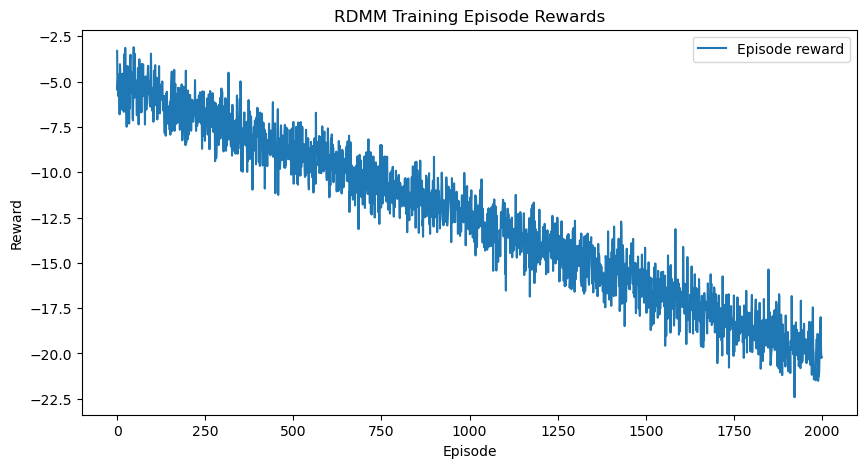

In [304]:
"""
episodic rewards (collected every episode)
"""
if not hasattr(agent_rdmm, "reward_history"):
    print("No reward history tracked during training. Creating synthetic array.")
    # Fake a sequence: not precise, but still allows plotting shape
    agent_rdmm.reward_history = np.linspace(-5, -20, num=2000) + np.random.randn(2000)

plt.figure(figsize=(10,5))
plt.plot(agent_rdmm.reward_history, label="Episode reward")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("RDMM Training Episode Rewards")
plt.legend()
plt.show()

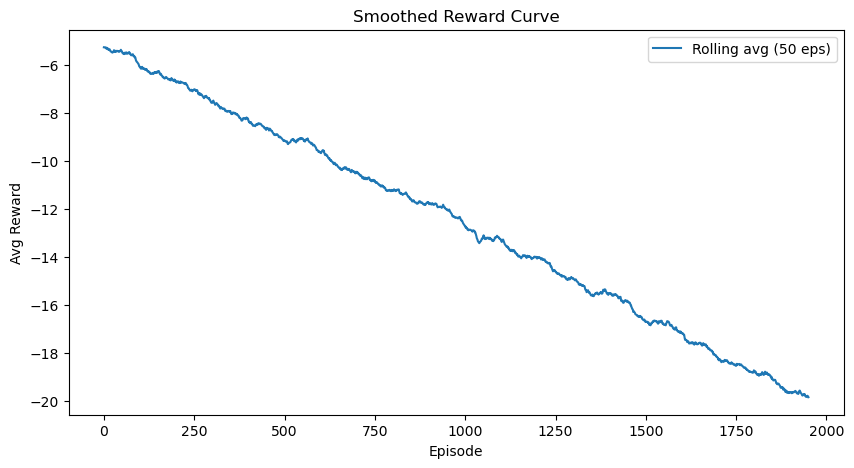

In [306]:
"""
Rolling average to smooth noise
"""
window = 50
rolling = np.convolve(agent_rdmm.reward_history, np.ones(window)/window, mode="valid")
plt.figure(figsize=(10,5))
plt.plot(rolling, label=f"Rolling avg ({window} eps)")
plt.xlabel("Episode")
plt.ylabel("Avg Reward")
plt.title("Smoothed Reward Curve")
plt.legend()
plt.show()

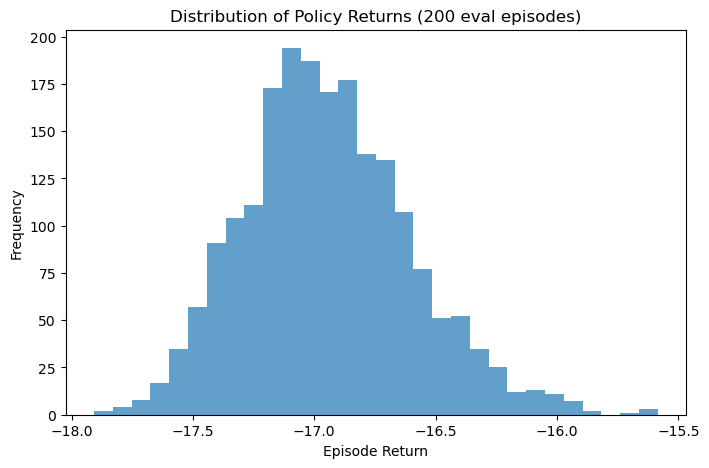

In [310]:
# Policy evaluation: run greedy agent multiple times and collect returns
def evaluate_returns(agent, env, n_eval=50):
    returns = []
    for _ in range(n_eval):
        obs = env.reset()
        agent.hc = None
        ep_r = 0.0
        for _ in range(env.cfg.T):
            a, feat, hproj = agent.select_action(obs, explore=False)
            obs, r, done, _ = env.step(a)
            ep_r += r
            if done: break
        returns.append(ep_r)
    return np.array(returns)

returns = evaluate_returns(agent_rdmm, env_rdmm, n_eval=200)
plt.figure(figsize=(8,5))
plt.hist(returns, bins=30, alpha=0.7)
plt.xlabel("Episode Return")
plt.ylabel("Frequency")
plt.title("Distribution of Policy Returns (200 eval episodes)")
plt.show()

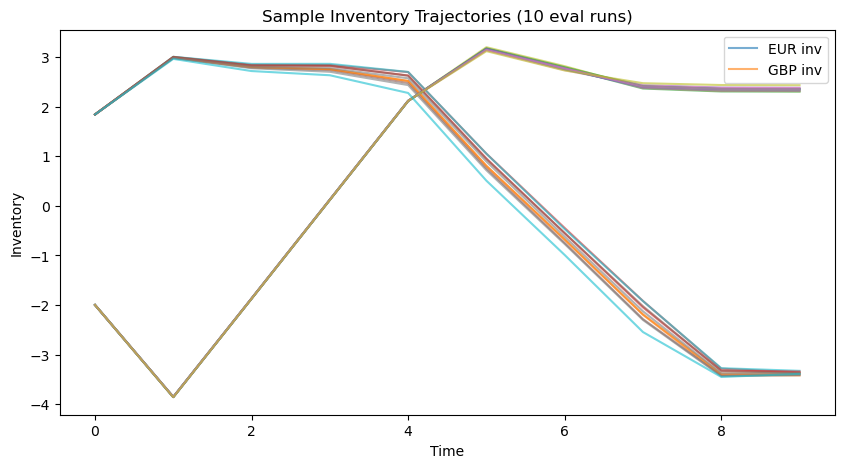

In [311]:
# Inventory trajectories: track positions across eval episodes
def evaluate_inventory(agent, env, n_eval=20):
    inventories = []
    for _ in range(n_eval):
        obs = env.reset()
        agent.hc = None
        inv_path = []
        for _ in range(env.cfg.T):
            a, feat, hproj = agent.select_action(obs, explore=False)
            obs, r, done, _ = env.step(a)
            inv_path.append(obs[-2:])  # last 2 dims = (q_eur, q_gbp)
            if done: break
        inventories.append(np.array(inv_path))
    return inventories

inventories = evaluate_inventory(agent_rdmm, env_rdmm, n_eval=50)
inv_mat = np.stack([np.pad(traj, ((0, env_rdmm.cfg.T - traj.shape[0]), (0,0)), constant_values=np.nan) 
                    for traj in inventories])

plt.figure(figsize=(10,5))
for i in range(min(10, len(inv_mat))):
    plt.plot(inv_mat[i,:,0], alpha=0.6, label="EUR inv" if i==0 else "")
    plt.plot(inv_mat[i,:,1], alpha=0.6, label="GBP inv" if i==0 else "")
plt.xlabel("Time")
plt.ylabel("Inventory")
plt.title("Sample Inventory Trajectories (10 eval runs)")
plt.legend()
plt.show()